# DN trajectory from cell neighbourhoods 

In [2]:
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix
import scanpy as sc
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
import seaborn as sb
import palantir
import dandelion as ddl

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
import milopy
import milopy.core as milo
import milopy.plot as milopl

In [4]:
sc.settings.set_figure_params(dpi = 160, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf')
plt.rcParams["figure.figsize"] = [6,6]
sb.set_palette('colorblind')

In [133]:
ct_order = ['DN(early)','DN(P)', 'DN(Q)','DP(P)','DP(Q)','ILC3','NK'] # didn't include ILC/NK as too few cells in postnatal thymic data
ct_color_map = dict(zip(ct_order, np.array(sb.color_palette('colorblind'))[range(len(ct_order))]))

In [6]:
# set working directory
%cd /lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript/

/lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript


In [7]:
# figure directory
fig_path = '/home/jovyan/mount/gdrive/VDJ_collab/plots_output/chenqu_jhub/'
sc.settings.figdir = fig_path

In [8]:
#### need to add this line to restore plotting function of scanpy
%matplotlib inline

In [160]:
plot = ['pseudotime','prob_NK','prob_T']

In [10]:
# import utils (in github folder utils)
import sys
sys.path.append('/lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript/utils')
from _chenqu_utils import *

# Load data

In [11]:
# object downloaded from https://developmental.cellatlas.io/thymus-development
adata_source = sc.read('downloaded_data/HTA08.v01.A05.Science_human_fig1.h5ad')

Only considering the two last: ['.Science_human_fig1', '.h5ad'].
Only considering the two last: ['.Science_human_fig1', '.h5ad'].


/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [12]:
adata_source

AnnData object with n_obs × n_vars = 255901 × 33694
    obs: 'Anno_level_1', 'Anno_level_2', 'Anno_level_3', 'Anno_level_4', 'Anno_level_5', 'Anno_level_fig1', 'Sample', 'donor', 'organ', 'sort', 'method', 'file', 'Anno_stage', 'Age', 'Gender', 'Source'
    obsm: 'X_umap'

In [13]:
# subset to paediatric & adult samples
adata = adata_source[adata_source.obs['donor'].str.startswith(('P','T','A'))]

# Load abTCR data

In [14]:
# raw VDJ sequencing data was downloaded from ArrayExpress (accession number E-MTAB-8581)
# remapped with cellranger vdj pipeline (v6.1.2) with cellranger vdj reference (v5.0.0)
# 16 samples from A16, A43, T03, T06
import os.path
from os import path

# collapse by sample, file
smp_list = adata.obs[['Sample','file']]
smp_list = smp_list.groupby(['Sample'], as_index=False).first()
# add a column of vdj_path
smp_list['vdj_path'] = ['/warehouse/cellgeni/tic-1144/E-MTAB-8581/VDJ/'+smp+'_vdj' for smp in smp_list['Sample']]
# only filter for samples that have had vdj done
smp_list = smp_list.loc[[path.exists(vdj_path) for vdj_path in smp_list['vdj_path']],:]

In [102]:
from tqdm import tqdm
tcrab = {}
for x, y in tqdm(zip(smp_list['vdj_path'], smp_list['file'])):
    
    file = x+'/outs/all_contig_annotations.json'

    tmp = ddl.read_10x_vdj(file)
    
    # update cell_id to librarry-barcode
    tmp.data['cell_id']= [y + '-' + z.split('-1')[0] for z in tmp.data['cell_id']]
    ddl.utl.update_metadata(tmp) # update the metadata_names
    # only leave contigs with cell_id in adata
    tmp = tmp[tmp.data['cell_id'].isin(adata.obs_names)].copy()
    
    tcrab[x] = tmp
len(tcrab)

16it [17:21, 65.10s/it] 


16

In [103]:
# concatenate
tcrab = ddl.concat([tcrab[x] for x in tcrab], prefixes = list(tcrab.keys()))
tcrab

Dandelion class object with n_obs = 36757 and n_contigs = 117886
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'complete_vdj', 'vj_in_frame', 'junction', 'junction_aa', 'locus', 'v_call', 'j_call', 'c_call', 'd_call', 'consensus_count', 'duplicate_count', 'cdr3_start', 'cdr3_end', 'fwr1_start', 'fwr1_end', 'fwr1', 'fwr1_aa', 'cdr1_start', 'cdr1_end', 'cdr1', 'cdr1_aa', 'fwr2_start', 'fwr2_end', 'fwr2', 'fwr2_aa', 'cdr2_start', 'cdr2_end', 'cdr2', 'cdr2_aa', 'fwr3_start', 'fwr3_end', 'fwr3', 'fwr3_aa', 'fwr4_start', 'fwr4_end', 'fwr4', 'fwr4_aa', 'clone_id', 'raw_consensus_id_10x', 'exact_subclonotype_id_10x', 'high_confidence_10x', 'filtered_10x', 'is_cell_10x', 'is_asm_cell_10x', 'rearrangement_status'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junc

In [104]:
# library_type is set to filter out genes that are not TRA/TRB (in 'locus' column) as this library is abTCR
tcrab.data['sequence_alignment'] = tcrab.data['sequence']
tcrab_checked, trab_adata = ddl.pp.check_contigs(tcrab, adata, productive_only = False, library_type = 'tr-ab')
tcrab_checked

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Preparing data: 117884it [00:30, 3849.14it/s]
Scanning for poor quality/ambiguous contigs: 100%|██████████| 36755/36755 [04:07<00:00, 148.49it/s]


Dandelion class object with n_obs = 36409 and n_contigs = 117884
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'complete_vdj', 'vj_in_frame', 'junction', 'junction_aa', 'locus', 'v_call', 'j_call', 'c_call', 'd_call', 'consensus_count', 'duplicate_count', 'cdr3_start', 'cdr3_end', 'fwr1_start', 'fwr1_end', 'fwr1', 'fwr1_aa', 'cdr1_start', 'cdr1_end', 'cdr1', 'cdr1_aa', 'fwr2_start', 'fwr2_end', 'fwr2', 'fwr2_aa', 'cdr2_start', 'cdr2_end', 'cdr2', 'cdr2_aa', 'fwr3_start', 'fwr3_end', 'fwr3', 'fwr3_aa', 'fwr4_start', 'fwr4_end', 'fwr4', 'fwr4_aa', 'clone_id', 'raw_consensus_id_10x', 'exact_subclonotype_id_10x', 'high_confidence_10x', 'filtered_10x', 'is_cell_10x', 'is_asm_cell_10x', 'rearrangement_status', 'sequence_alignment', 'ambiguous'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'jun

In [136]:
trab_adata.write('write/thymusatlas_postnatal_tcr.h5ad')

In [15]:
trab_adata = sc.read('write/thymusatlas_postnatal_tcr.h5ad')

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# Filter cells

In [134]:
# only take samples that had TCR sequencing done
adata_abtcr = trab_adata[trab_adata.obs['file'].isin(smp_list['file'])].copy()

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### subset cells to DN onwards, and cells with TRBJ

In [135]:
# filter cells that are within cell types of desire
bdata = adata_abtcr[adata_abtcr.obs['Anno_level_5'].isin(ct_order)]
# filter cells that have TRBJ
bdata = bdata[bdata.obs['j_call_abT_VDJ_main'].str.startswith('TRBJ')]

In [136]:
bdata

View of AnnData object with n_obs × n_vars = 18234 × 33694
    obs: 'Anno_level_1', 'Anno_level_2', 'Anno_level_3', 'Anno_level_4', 'Anno_level_5', 'Anno_level_fig1', 'Sample', 'donor', 'organ', 'sort', 'method', 'file', 'Anno_stage', 'Age', 'Gender', 'Source', 'has_contig', 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'duplicate_count_abT_VDJ', 'duplicate_count_abT_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_abT_VDJ_main', 'd_call_abT_VDJ_main', 'j_call_abT_VDJ_main', 'v_call_abT_VJ_main', 'j_call_abT_VJ_main', 'isotyp

### Select neighbourhoods 

In [137]:
sc.pp.highly_variable_genes(bdata)
sc.pp.pca(bdata, n_comps = 50, use_highly_variable = True, svd_solver = 'arpack', random_state = 1712)

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [134]:
#pip install harmony-pytorch

  Using cached harmony_pytorch-0.1.7-py3-none-any.whl (8.4 kB)
     |████████████████████▊           | 574.5 MB 97.8 MB/s eta 0:00:04

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |███████████████████████████████ | 862.3 MB 87.3 MB/s eta 0:00:012ta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 887.4 MB 1.9 kB/s 
     |████████████████████████████▏   | 279.5 MB 94.7 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 317.1 MB 30 kB/s 
     |████████████████████████████████| 21.0 MB 76.1 MB/s eta 0:00:01
     |████████████████████████████████| 849 kB 75.2 MB/s eta 0:00:01
     |█████████████████████▋          | 376.0 MB 97.0 MB/s eta 0:00:02        | 99.5 MB 88.5 MB/s eta 0:00:064.7 MB 84.9 MB/s eta 0:00:04

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 557.1 MB 14 kB/s s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [138]:
from harmony import harmonize
Z = harmonize(bdata.obsm['X_pca'], bdata.obs, batch_key = ['donor'])
bdata.obsm['X_pca'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


In [139]:
# recalculate neighborhood - ideally using X_pca but not available here
#sc.pp.neighbors(bdata, use_rep = "X_umap", n_neighbors = 50)

In [140]:
sc.pp.neighbors(bdata, n_neighbors=30)

In [141]:
sc.tl.umap(bdata, random_state = 1712)

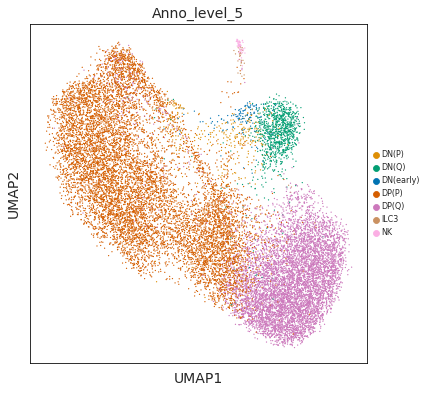

In [142]:
plt.rcParams["figure.figsize"] = [6,6]
sc.pl.umap(bdata,color=['Anno_level_5'],legend_loc='right margin',legend_fontsize=8,palette = ct_color_map)

In [143]:
milo.make_nhoods(bdata)

In [144]:
# build neighbourhood adata in bdata.uns['nhood_adata']
milopy.core.count_nhoods(bdata, sample_col='file') # this step is needed to build bdata.uns['nhood_adata'] and sample_col can be anything
# this step is needed for plotting below
milopy.utils.build_nhood_graph(bdata)

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [145]:
# assign neighbourhood celltype by majority voting
# results are in bdata.uns['nhood_adata'].obs['nhood_annotation'] & bdata.uns['nhood_adata'].obs['nhood_annotation_frac'] 
milopy.utils.annotate_nhoods(bdata, anno_col='Anno_level_5')

Now neighbourhood adata is stored in bdata.uns['nhood_adata']

# Create neighbourhood VDJ feature space

In [146]:
# function for making neighbourhood vdj feature space
# cols are the columns of VDJ to be used here
nhood_adata = ddl.tl.vdj_pseudobulk(bdata, pbs = bdata.obsm['nhoods'], obs_to_take = 'Anno_level_5', extract_cols=['j_call_abT_VDJ_main'])

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [147]:
nhood_adata

AnnData object with n_obs × n_vars = 773 × 14
    obs: 'Anno_level_5', 'Anno_level_5_fraction', 'cell_count'
    obsm: 'pbs'

     nhood_adata is the new neighbourhood VDJ feature space, whereby each observation is a cell neighbourhood
     VDJ usage frequency stored in nhood_adata.X
     VDJ genes stored in nhood_adata.var
     neighbourhood metadata stored in nhood_adata.obs
     can visualise the data using PCA or UMAP (see below)

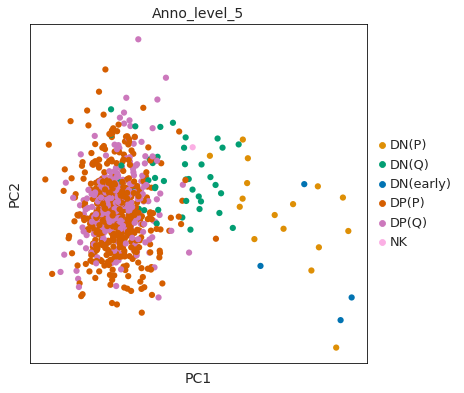

In [148]:
sc.pp.pca(nhood_adata, random_state = 1712)
sc.pl.pca(nhood_adata, color=['Anno_level_5'],palette=ct_color_map)

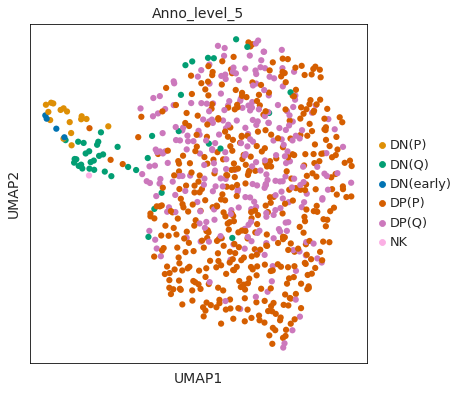

In [149]:
sc.pp.neighbors(nhood_adata, random_state = 1712)
sc.tl.umap(nhood_adata, random_state = 1712)
sc.pl.umap(nhood_adata, color=['Anno_level_5'],palette=ct_color_map)

# Use palantir to do pseudotime

In [150]:
# Run diffusion maps
pca_projections = pd.DataFrame(nhood_adata.obsm['X_pca'], index=nhood_adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)

Determing nearest neighbor graph...


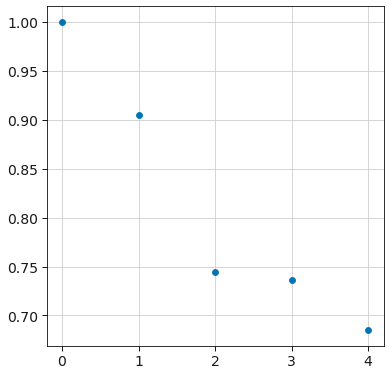

In [151]:
plt.scatter(np.arange(5), dm_res['EigenValues'])

In [152]:
ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=2)

In [153]:
# select the start and end points
# start
tmp = nhood_adata[nhood_adata.obs['Anno_level_5'] == 'DN(early)']
rootcell = np.argmax(tmp.obsm['X_pca'][:,0])
rootcell = tmp.obs_names[rootcell]
nhood_adata.obs['rootcell'] = 0
nhood_adata.obs.loc[rootcell,'rootcell'] = 1

In [154]:
# end
tmp1 = nhood_adata[nhood_adata.obs['Anno_level_5'] == 'NK']
endcell1 = np.argmin(tmp1.obsm['X_pca'][:,0])
endcell1 = tmp1.obs_names[endcell1]
tmp2 = nhood_adata[nhood_adata.obs['Anno_level_5'] == 'DP(Q)']
endcell2 = np.argmin(tmp2.obsm['X_pca'][:,0])
endcell2 = tmp2.obs_names[endcell2]

terminal_states = pd.Series(['NK','T'], 
                           index=[endcell1,endcell2])

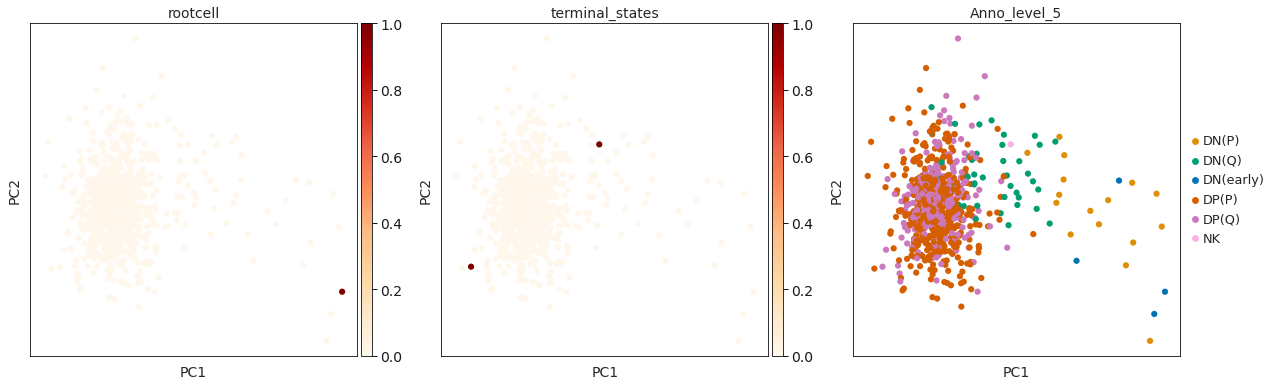

In [155]:
# plot rootcell and terminal states
nhood_adata.obs['terminal_states'] = 0
nhood_adata.obs.loc[terminal_states.index, 'terminal_states'] = 1
plt.rcParams["figure.figsize"] = [6,6]
sc.pl.pca(nhood_adata,color=['rootcell','terminal_states','Anno_level_5'],color_map='OrRd')

Compute pseudotime & fate probabilities 

In [156]:
pr_res = palantir.core.run_palantir(ms_data,  rootcell, num_waypoints=500, 
                                    terminal_states = terminal_states.index)

Sampling and flocking waypoints...
Time for determining waypoints: 0.001305997371673584 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.12211402257283528 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/palantir/core.py:447: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/palantir/core.py:450: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [157]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

In [158]:
# function to add pseudotime information onto nhood_adata
# pseudotime stored in .obs['pseudotime'], branch probabilities in .obs['prob_'+terminal_state_name]
ddl.tl.pseudotime_transfer(adata = nhood_adata, pr_res = pr_res, suffix = '_nhood_vdj')

AnnData object with n_obs × n_vars = 773 × 14
    obs: 'Anno_level_5', 'Anno_level_5_fraction', 'cell_count', 'rootcell', 'terminal_states', 'pseudotime_nhood_vdj', 'prob_NK_nhood_vdj', 'prob_T_nhood_vdj'
    uns: 'pca', 'Anno_level_5_colors', 'neighbors', 'umap'
    obsm: 'pbs', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

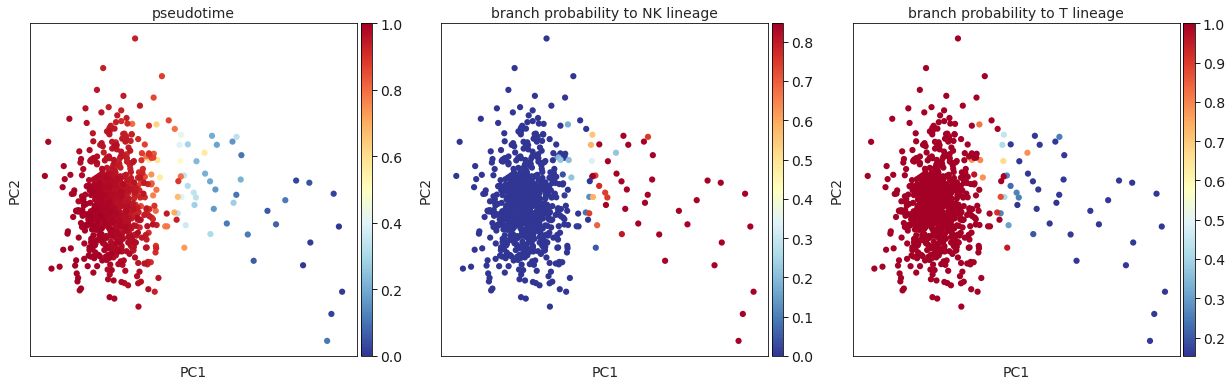

In [161]:
sc.pl.pca(nhood_adata,color=[term + '_nhood_vdj' for term in plot],title=['pseudotime','branch probability to NK lineage','branch probability to T lineage'])

# project pseudotime and branch probabilities back to cells

In [162]:
# project pseudotime and branch probabilities back to cell. results stored in cdata.obs
cdata = ddl.tl.project_pseudotime_to_cell(adata = bdata, 
                               pb_adata = nhood_adata, 
                               term_states=['NK','T'], 
                               suffix = '_nhood_vdj')
# cdata is bdata removing cells that don't belong to any neighbourhood 

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


number of cells removed due to not belonging to any neighbourhood 128


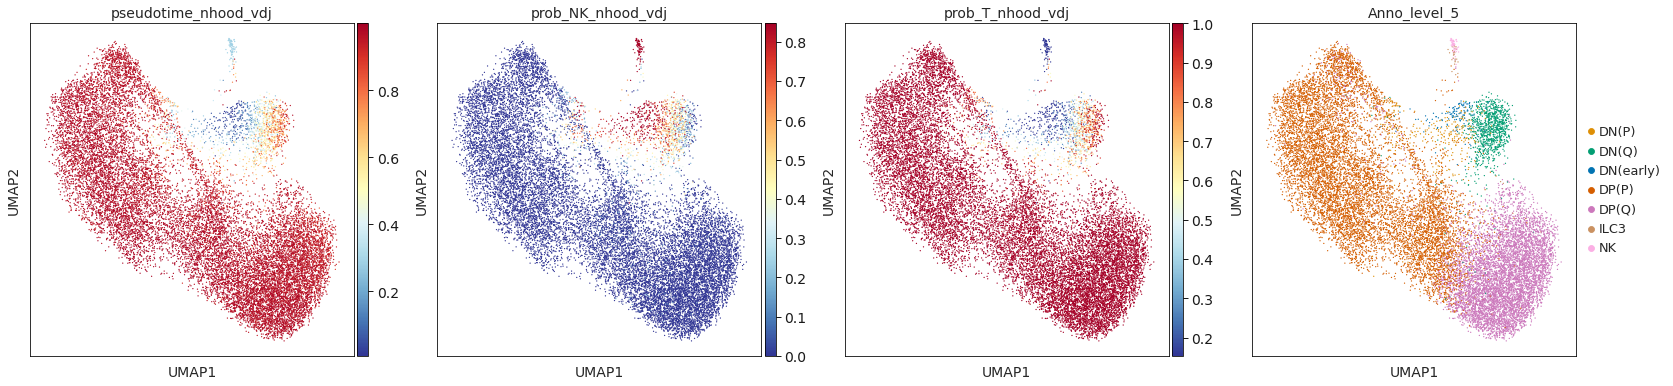

In [163]:
sc.pl.umap(cdata,color=[term + '_nhood_vdj' for term in plot]+['Anno_level_5'])

In [208]:
import random
cdata.obs['prob_NK_nhood_vdj_rand'] = [num + random.randint(0,100)/5000 for num in cdata.obs['prob_NK_nhood_vdj']]
cdata.obs['pseudotime_nhood_vdj_rand'] = [num + random.randint(0,100)/10000 for num in cdata.obs['pseudotime_nhood_vdj']]

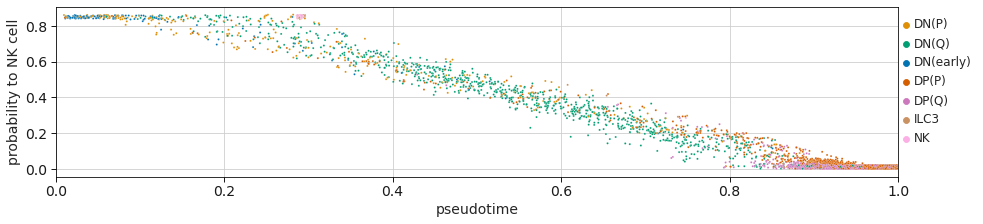

In [211]:
fig, ax = plt.subplots(figsize=(15,3))
plt.subplots_adjust(hspace=0.6)
ax= sb.scatterplot(data=cdata.obs, x ='pseudotime_nhood_vdj_rand',y='prob_NK_nhood_vdj_rand',s=4,hue='Anno_level_5',palette = ct_color_map)
ax.set(xlim=(0, 1))
#ax.set(ylim=(0, 1))
ax.set_ylabel('probability to NK cell', fontsize=14)    
ax.set_xlabel('pseudotime')
h,l = ax.get_legend_handles_labels()
l1 = ax.legend(h[:10],l[:10], loc='upper right',bbox_to_anchor=(1.1, 1),frameon=False, fontsize='large')

plt.savefig(fig_path+'dn_pseudotime_postnatal.pdf',bbox_inches='tight')

# Gene expression trends with pseudotime in DN T cells

In [212]:
cdata.var_names_make_unique()

In [213]:
cdata_DN = cdata[cdata.obs['Anno_level_5'].isin(['DN(early)','DN(P)','DN(Q)'])]

Plot known TFs in murine DN development

In [214]:
markers = ['HES1','TCF7','GATA3','BCL11B','LEF1','ETS1','SPI1','LYL1','HHEX','BCL11A','HOXA9','MEF2C','TCF3','IKZF1','RUNX1','TCF12','GFI1']

In [215]:
gene_summary = bin_expression(adata = cdata_DN, bin_no = 100, genes = markers, pseudotime_col='pseudotime_nhood_vdj')

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide


<ipython-input-216-a2faba9b9c29>:3: UserWarning: FixedFormatter should only be used together with FixedLocator


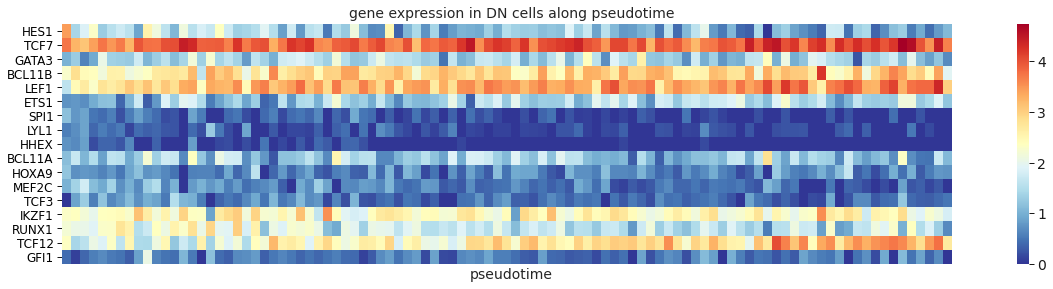

In [216]:
plot = gene_summary.copy()
fig, ax = plt.subplots(figsize=(20,plot.shape[0]/4))
ax.set_yticklabels(plot.index,size=12)
ax.tick_params(left=True, bottom=False)
ax = sb.heatmap(plot,cmap = 'RdYlBu_r', xticklabels=False)
ax.set_xlabel('pseudotime')
ax.set_title('gene expression in DN cells along pseudotime')

# change y tick labels 
#marker_diff = ['HES1','GATA3','BCL11A','TCF3','IKZF1','RUNX1','GFI1']
marker_diff = []
for i, tick_label in enumerate(ax.axes.get_yticklabels()):
    if tick_label.get_text() in marker_diff:
        tick_label.set_color("red")
    else:
        tick_label.set_color("black")
plt.savefig(fig_path+'dn_pseudotime_tf_selected_postnatal.pdf',bbox_inches='tight')